
# Hierarchical Clustering — Visual Guide & Diagnostics

This notebook builds 2D synthetic datasets and demonstrates **hierarchical clustering** with:
- **Dendrograms** and how to **cut** them to get clusters
- Linkage methods: **ward**, **complete**, **average**, **single**
- Distance metrics: **euclidean** and **cosine** (for average/complete/single)
- **Silhouette vs number of clusters** to pick a cut height
- **Cophenetic correlation** (how well the tree preserves pairwise distances)
- **Reordered distance matrix** (block structure after clustering)
- **Effect of feature scaling**
- Simple **stability check** via bootstrapped Adjusted Rand Index (ARI)

In [26]:
import numpy as np
import matplotlib.pyplot as plt, warnings

from sklearn.datasets import make_blobs, make_moons
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster, cophenet
from scipy.spatial.distance import pdist, squareform

np.random.seed(2025)
warnings.filterwarnings("ignore")

# Primary dataset: 2D blobs with 4 centers (unequal stds for variety)
X, y_true = make_blobs(n_samples=900, centers=[(-4,0),(0,0),(4,1),(4,-2)],
                       cluster_std=[0.8,1.2,0.6,0.9], random_state=2025)

def plot_scatter_by_labels(X, labels, title=""):
    plt.figure(figsize=(6,5))
    plt.scatter(X[:,0], X[:,1], c=labels, s=14, alpha=0.9)
    plt.title(title)
    plt.xlabel("x1"); plt.ylabel("x2")
    plt.tight_layout(); plt.show()

def plot_dendro(Z, title="Dendrogram", p=None):
    plt.figure(figsize=(8,4.8))
    dendrogram(Z, truncate_mode="lastp" if p else None, p=p, no_labels=True, color_threshold=None)
    plt.title(title); plt.xlabel("samples"); plt.ylabel("distance")
    plt.tight_layout(); plt.show()

def reorder_distance_matrix(X, method="ward", metric="euclidean", title="Reordered distance matrix"):
    D = pdist(X, metric=metric)
    Z = linkage(D, method=method, metric=None if method=="ward" else metric)
    dn = dendrogram(Z, no_plot=True)
    order = dn["leaves"]
    D_sq = squareform(D)
    D_re = D_sq[np.ix_(order, order)]
    plt.figure(figsize=(5.5,5))
    plt.imshow(D_re, aspect="auto", origin="lower")
    plt.title(title + f"\n(method={method}, metric={metric})")
    plt.xlabel("reordered samples"); plt.ylabel("reordered samples")
    plt.colorbar(); plt.tight_layout(); plt.show()


## 1) Dendrogram (Ward / Euclidean) and example cuts

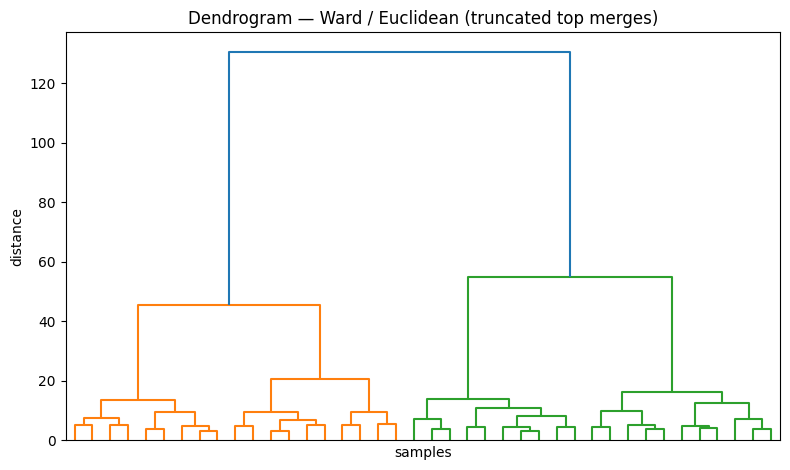

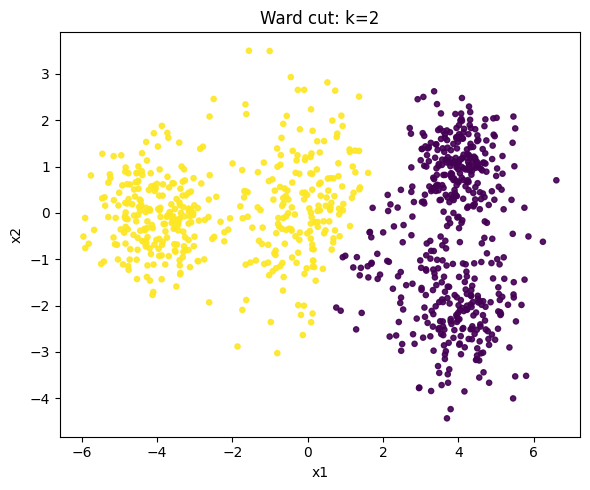

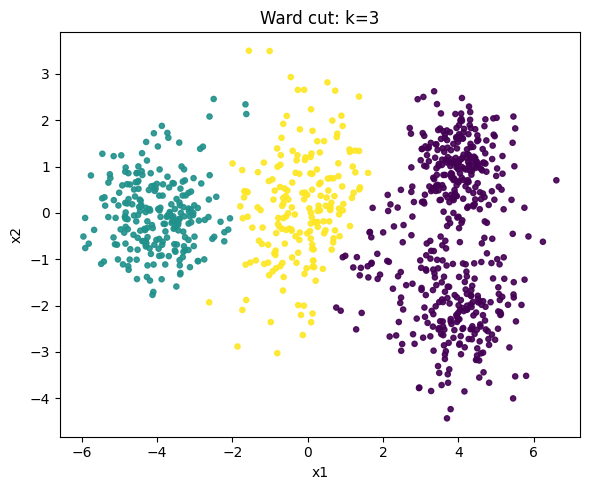

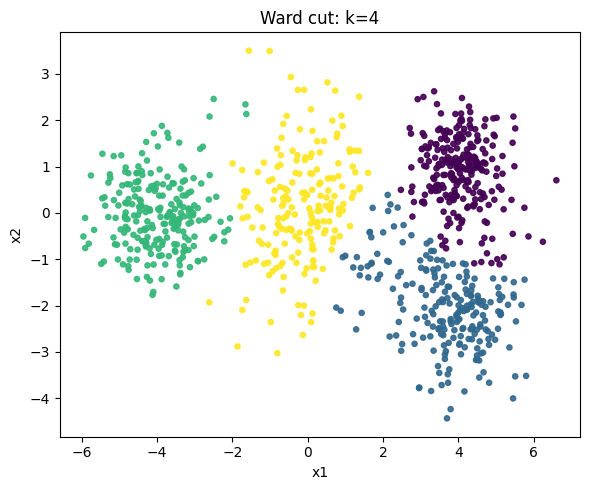

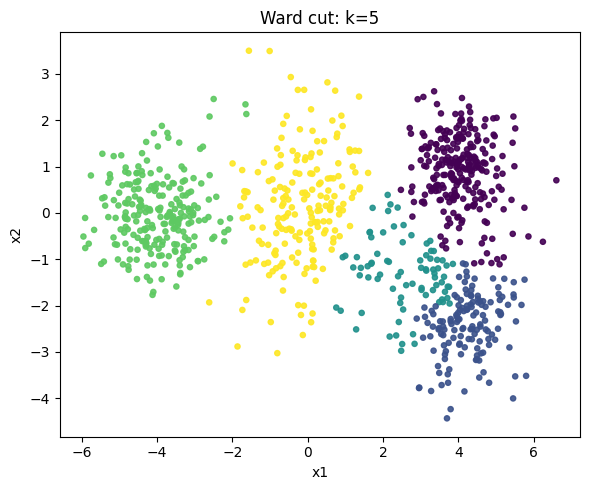

In [27]:
# Ward linkage uses Euclidean distance and minimizes within-cluster variance
Z_ward = linkage(X, method="ward")
plot_dendro(Z_ward, title="Dendrogram — Ward / Euclidean (truncated top merges)", p=40)

# Example: cut into K clusters (maxclust) and visualize
for k in [2, 3, 4, 5]:
    labels = fcluster(Z_ward, t=k, criterion="maxclust")
    plot_scatter_by_labels(X, labels, f"Ward cut: k={k}")

## 2) Linkage comparison (Ward, Complete, Average, Single)

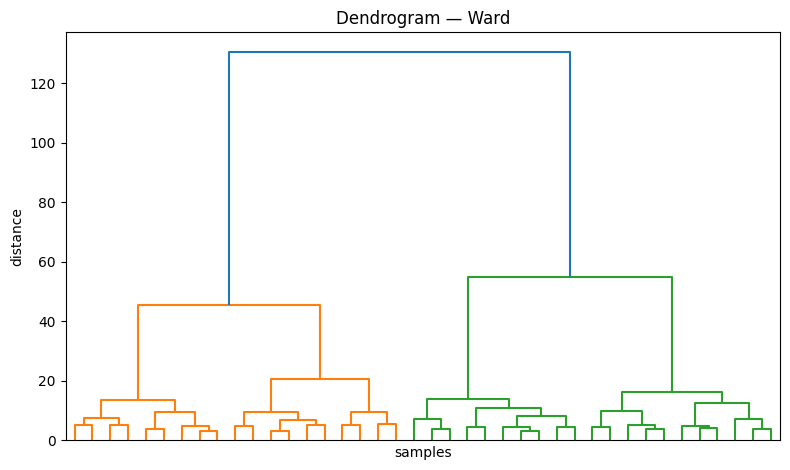

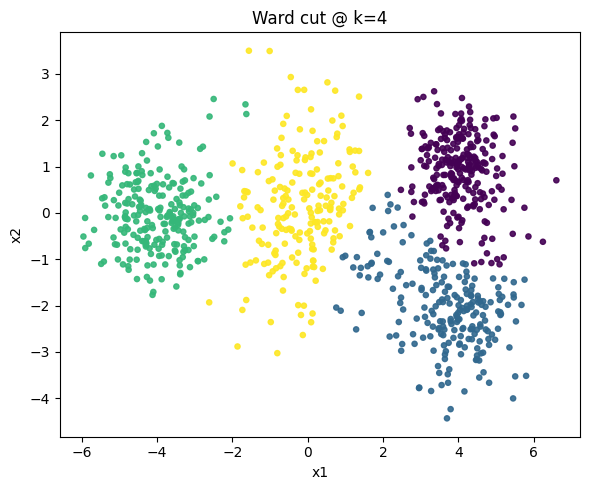

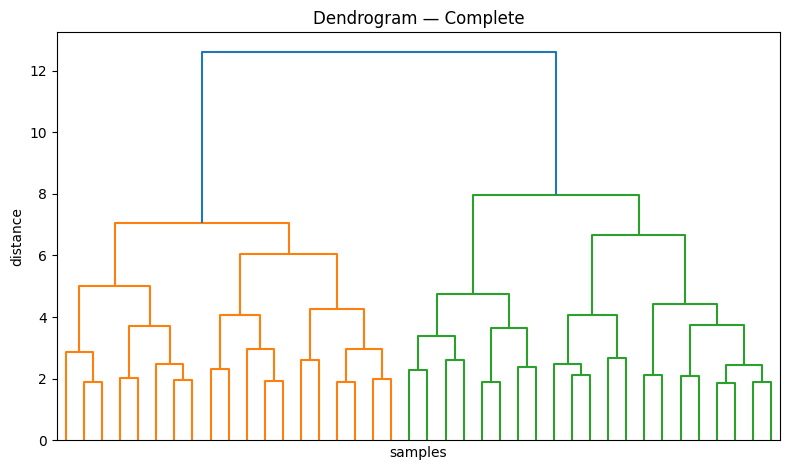

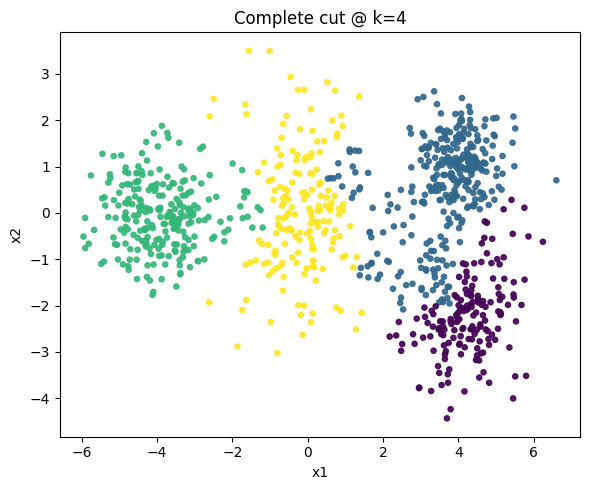

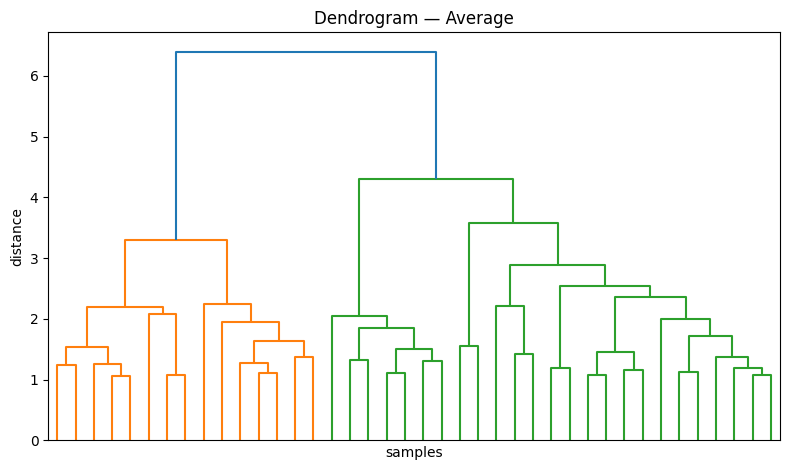

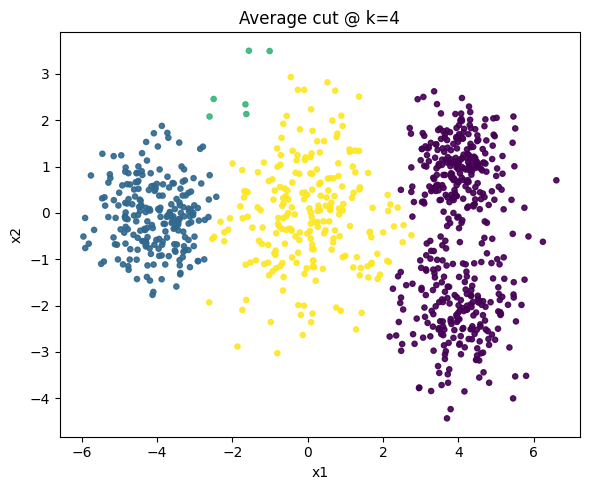

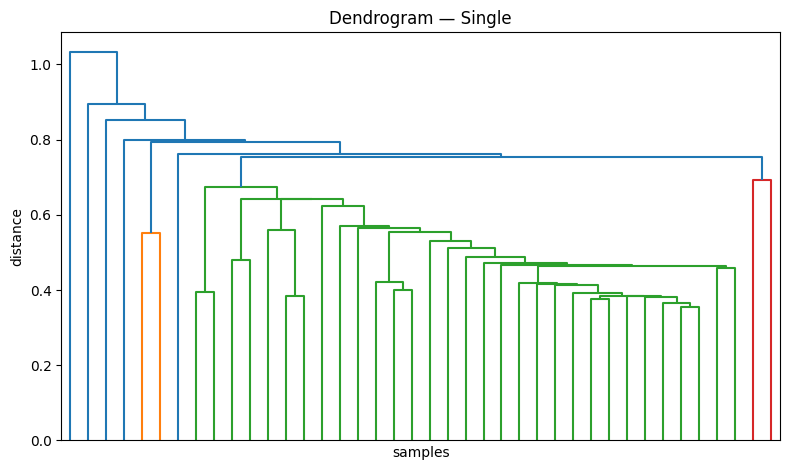

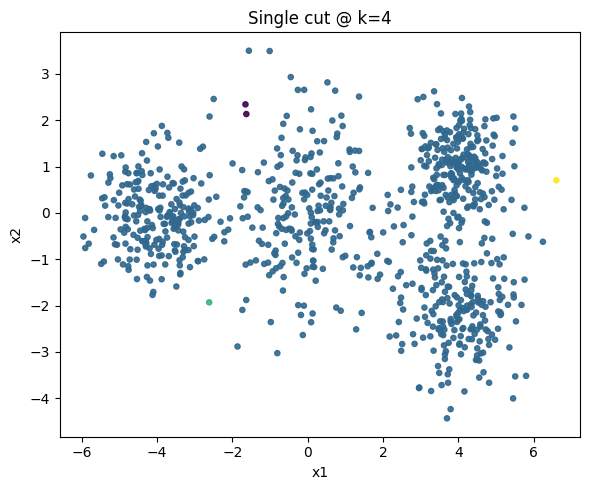

In [28]:
for method in ["ward", "complete", "average", "single"]:
    Z = linkage(X, method=method) if method=="ward" else linkage(pdist(X), method=method)
    plot_dendro(Z, title=f"Dendrogram — {method.title()}", p=40)
    labels = fcluster(Z, t=4, criterion="maxclust")
    plot_scatter_by_labels(X, labels, f"{method.title()} cut @ k=4")

## 3) Distance metrics (euclidean vs cosine) with Average/Complete/Single

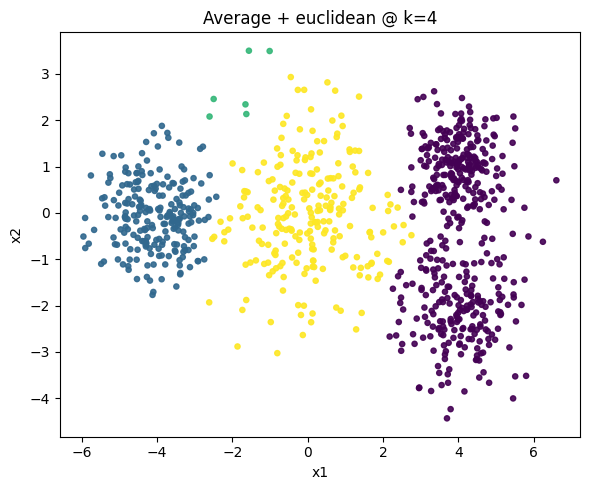

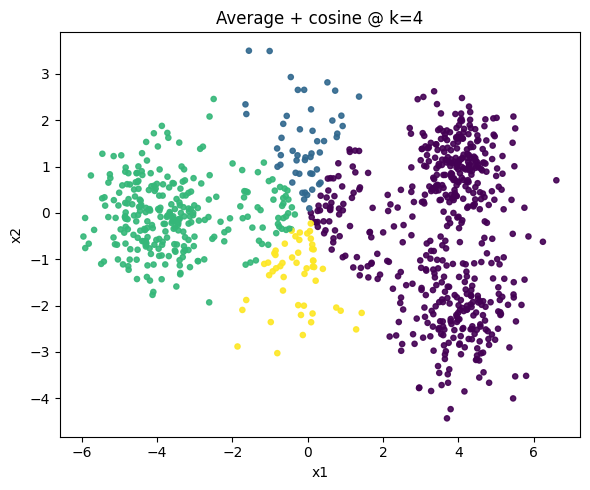

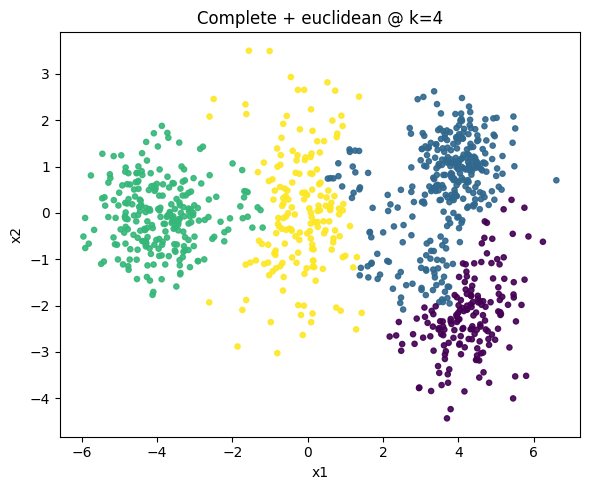

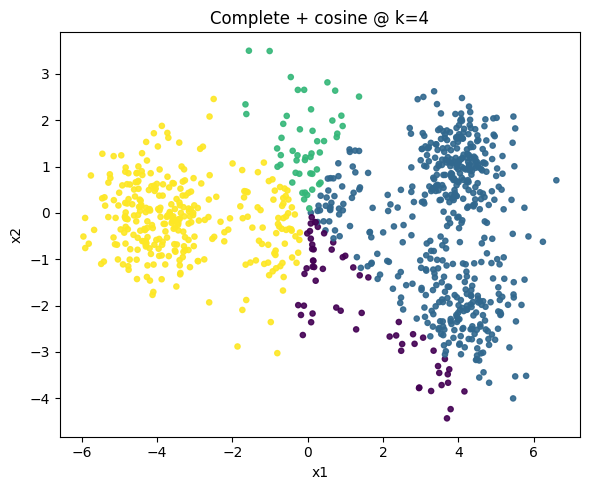

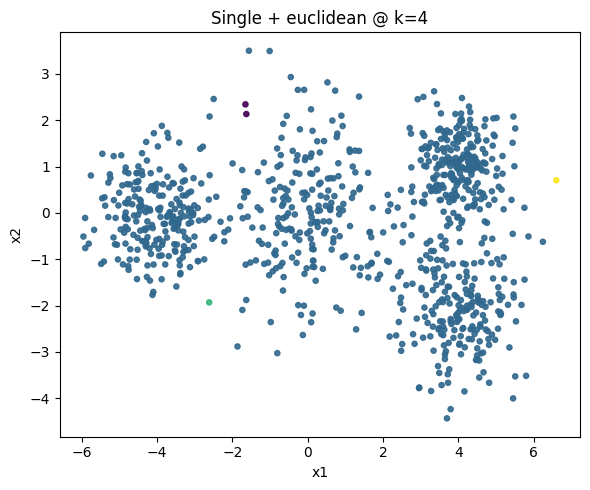

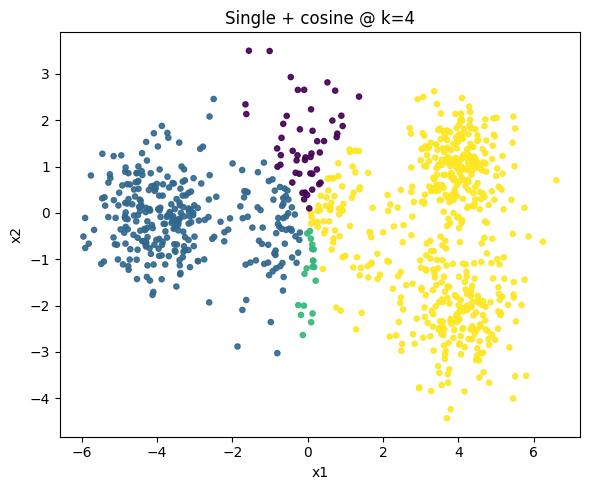

In [29]:
for method in ["average", "complete", "single"]:
    for metric in ["euclidean", "cosine"]:
        D = pdist(X, metric=metric)
        Z = linkage(D, method=method)
        labels = fcluster(Z, t=4, criterion="maxclust")
        plot_scatter_by_labels(X, labels, f"{method.title()} + {metric} @ k=4")

## 4) Silhouette vs number of clusters (Ward linkage)

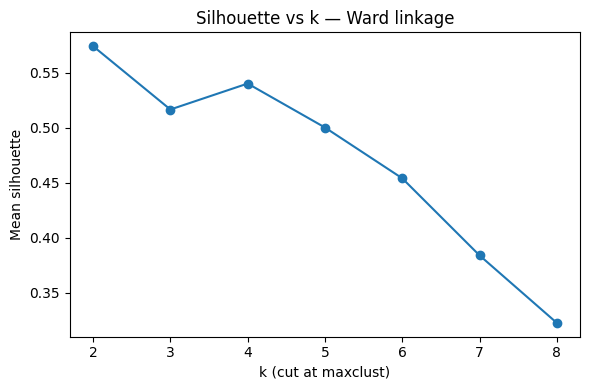

In [30]:
Ks = range(2, 9)
sils = []
Z = linkage(X, method="ward")
for k in Ks:
    labels = fcluster(Z, t=k, criterion="maxclust")
    sils.append(silhouette_score(X, labels))

plt.figure(figsize=(6,4))
plt.plot(list(Ks), sils, marker="o")
plt.xlabel("k (cut at maxclust)"); plt.ylabel("Mean silhouette")
plt.title("Silhouette vs k — Ward linkage")
plt.tight_layout(); plt.show()

## 5) Cophenetic correlation (tree fidelity to distances)

In [32]:
for method in ["ward","complete","average","single"]:
    if method == "ward":
        # Ward expects the observation matrix (uses Euclidean internally)
        Z = linkage(X, method="ward")
        D = pdist(X)  # for comparing shapes with coph_dists
    else:
        D = pdist(X)  # condensed distance vector
        Z = linkage(D, method=method)

    coph_corr, coph_dists = cophenet(Z, D)  # correct order
    # Sanity check: lengths should match
    assert D.shape == coph_dists.shape, (D.shape, coph_dists.shape)

    # (Optional) recompute manually; should be ~== coph_corr
    corr_manual = np.corrcoef(D, coph_dists)[0, 1]

    print(f"Method={method:8s} | cophenetic corr = {coph_corr:.3f} (manual={corr_manual:.3f})")

Method=ward     | cophenetic corr = 0.788 (manual=0.788)
Method=complete | cophenetic corr = 0.786 (manual=0.786)
Method=average  | cophenetic corr = 0.775 (manual=0.775)
Method=single   | cophenetic corr = 0.452 (manual=0.452)


## 6) Reordered distance matrix (block structure after clustering)

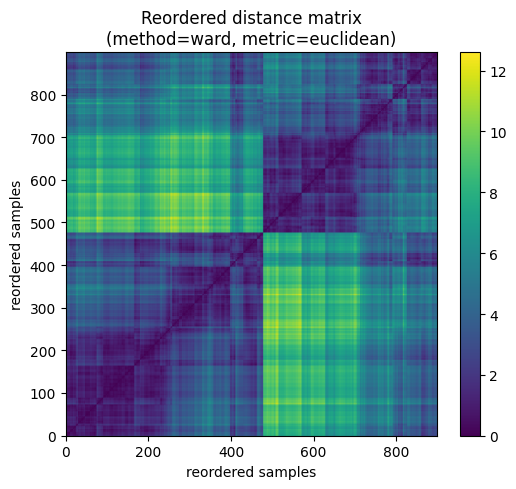

In [33]:
reorder_distance_matrix(X, method="ward", metric="euclidean", title="Reordered distance matrix")

## 7) Effect of feature scaling

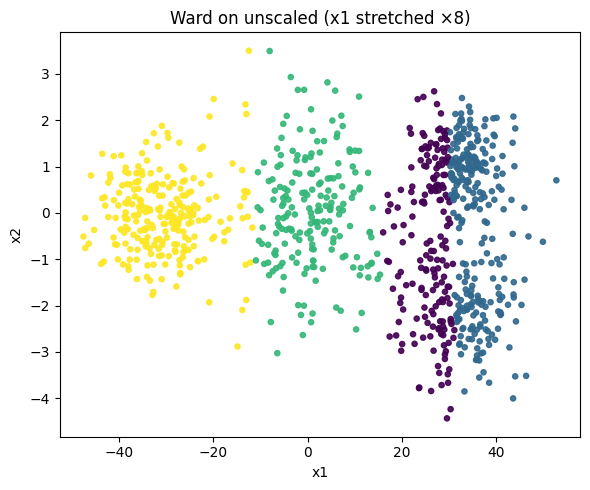

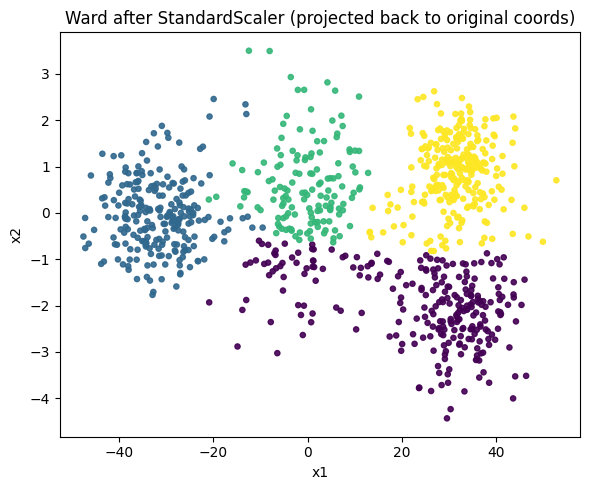

In [34]:
X_skew = X.copy()
X_skew[:,0] *= 8.0  # stretch x1 to dominate distances

Z_unscaled = linkage(X_skew, method="ward")
labels_unscaled = fcluster(Z_unscaled, t=4, criterion="maxclust")
plot_scatter_by_labels(X_skew, labels_unscaled, "Ward on unscaled (x1 stretched ×8)")

scaler = StandardScaler().fit(X_skew)
X_scaled = scaler.transform(X_skew)
Z_scaled = linkage(X_scaled, method="ward")
labels_scaled = fcluster(Z_scaled, t=4, criterion="maxclust")
plot_scatter_by_labels(X_skew, labels_scaled, "Ward after StandardScaler (projected back to original coords)")

## 8) AgglomerativeClustering (sklearn) @ k=4 (Ward / Euclidean)

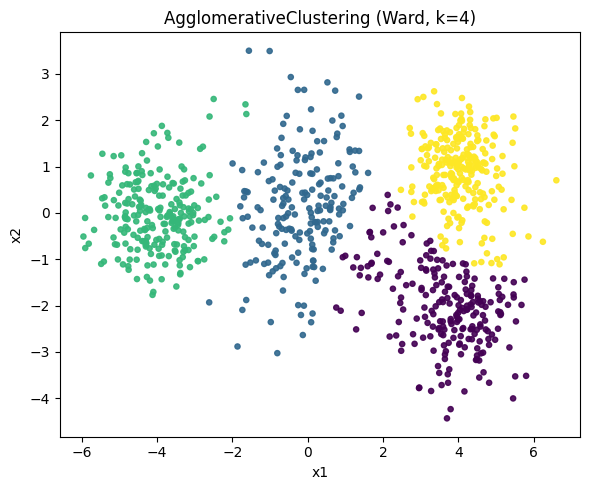

In [35]:
agg = AgglomerativeClustering(n_clusters=4, linkage="ward", metric="euclidean")
labels_agg = agg.fit_predict(X)
plot_scatter_by_labels(X, labels_agg, "AgglomerativeClustering (Ward, k=4)")

## 9) Stability check — bootstrap ARI (Ward / k=4)

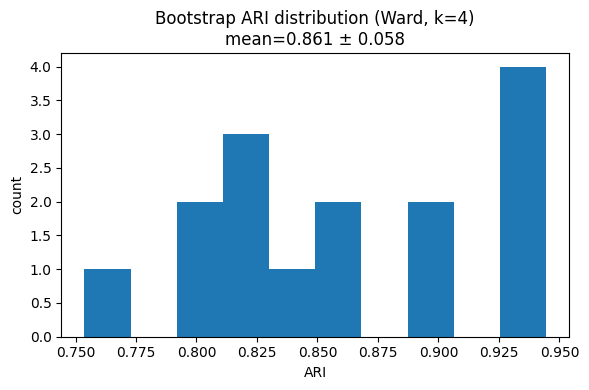

In [36]:
def bootstrap_labels(X, n=5):
    labels_list = []
    n_samples = len(X)
    for seed in range(n):
        rng = np.random.RandomState(seed)
        idx = rng.choice(n_samples, size=n_samples, replace=True)
        Xb = X[idx]
        lab = AgglomerativeClustering(n_clusters=4, linkage="ward").fit_predict(Xb)
        # Map back to original index length with -1 for missing; for ARI, compare overlapping indices only
        labels_list.append((idx, lab))
    return labels_list

boots = bootstrap_labels(X, n=6)
aris = []
# Compare every pair on their common indices
for i in range(len(boots)):
    for j in range(i+1, len(boots)):
        idx_i, lab_i = boots[i]
        idx_j, lab_j = boots[j]
        # find intersection of sampled indices
        inter, ia, ja = np.intersect1d(idx_i, idx_j, return_indices=True)
        if len(inter) > 0:
            aris.append(adjusted_rand_score(lab_i[ia], lab_j[ja]))

plt.figure(figsize=(6,4))
plt.hist(aris, bins=10)
plt.title(f"Bootstrap ARI distribution (Ward, k=4)\nmean={np.mean(aris):.3f} ± {np.std(aris):.3f}")
plt.xlabel("ARI"); plt.ylabel("count")
plt.tight_layout(); plt.show()

## 10) Non-globular shapes (moons) — method impact

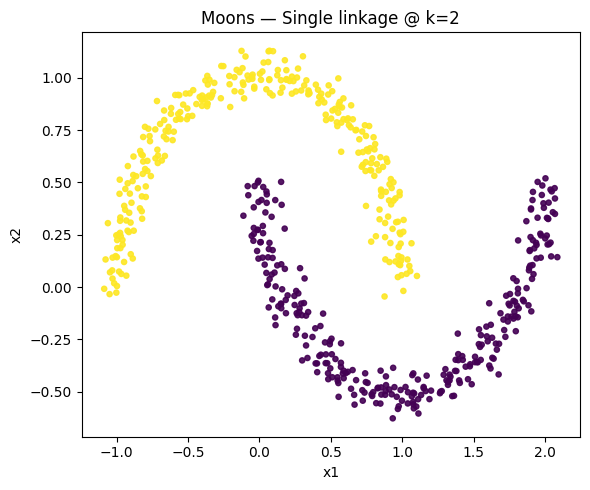

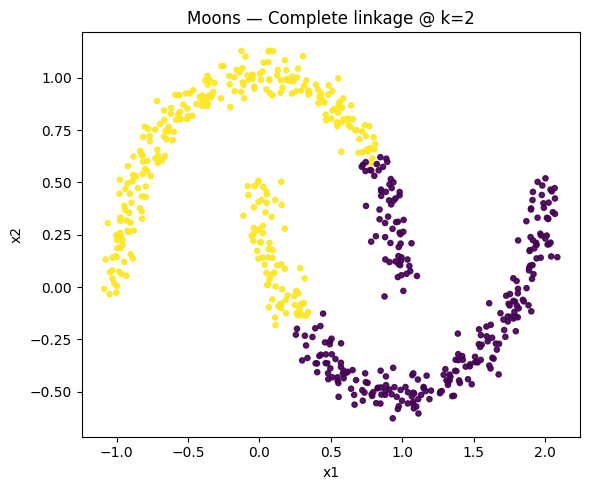

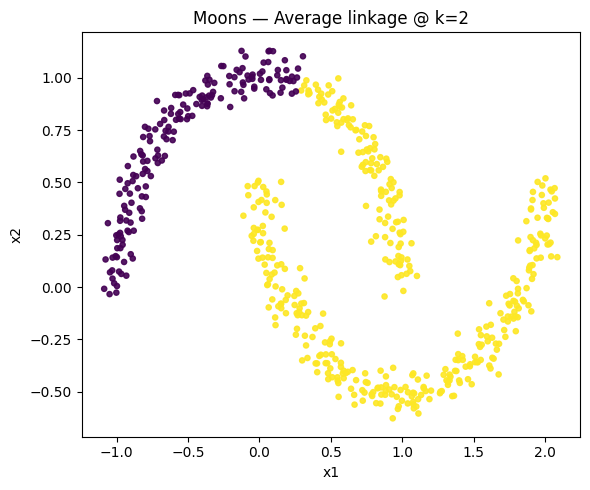

In [37]:
Xm, _ = make_moons(n_samples=600, noise=0.06, random_state=2025)

for method in ["single","complete","average"]:
    Zm = linkage(pdist(Xm), method=method)
    labels = fcluster(Zm, t=2, criterion="maxclust")
    plot_scatter_by_labels(Xm, labels, f"Moons — {method.title()} linkage @ k=2")